## GFS资料绘制天气分析图

这里我们利用python绘制netCDF格式的GFS资料天气分析图，完整的演示数据的读取和图形绘制。
其中第二部分利用Basemap绘制兰伯特投影的国界和海岸线。

In [1]:
%matplotlib inline
import cmaps
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
from mpl_toolkits.basemap import Basemap

In [2]:
def _read_gfs(dataset, varname):
    var = dataset.variables[varname]
    return var

读取500百帕高度场、风场和温度场。
注意np.nonzero和np.where用法

In [3]:
def read_gfs_data(fname, level=500., axis_lim=None):
    dataset = netCDF4.Dataset(fname)
    if axis_lim is None:
        lon_min, lon_max = 80., 130.
        lat_min, lat_max = 15., 50.
    else:
        lon_min, lon_max, lat_min, lat_max = axis_lim

    lv_varname = 'lv_ISBL0'
    lon_varname = 'lon_0'
    lat_varname = 'lat_0'
    s_lv = level * 100.  # plot 500hPa temperature height and wind
    lv_var = _read_gfs(dataset, lv_varname)[:]
    lv_index = np.nonzero(lv_var == s_lv)[0][0]

    lon_var = _read_gfs(dataset, lon_varname)[:]
    lat_var = _read_gfs(dataset, lat_varname)[:]

    lon_min_index = np.where(lon_var >= lon_min)[0][0]
    lon_max_index = np.where(lon_var <= lon_max)[0][-1]
    lat_min_index = np.where(lat_var >= lat_min)[0][-1]
    lat_max_index = np.where(lat_var <= lat_max)[0][0]

    # 转化为摄氏度
    t_varname = 'TMP_P0_L100_GLL0'
    t_var = _read_gfs(dataset, t_varname)[
        lv_index, lat_max_index: lat_min_index+1,
        lon_min_index:lon_max_index+1] - 273.15
    time_str = _read_gfs(dataset, t_varname).initial_time

    u_varname = 'UGRD_P0_L100_GLL0'
    v_varname = 'VGRD_P0_L100_GLL0'
    u_var = _read_gfs(dataset, u_varname)[
        lv_index, lat_max_index: lat_min_index+1,
        lon_min_index:lon_max_index+1]
    v_var = _read_gfs(dataset, v_varname)[
        lv_index, lat_max_index: lat_min_index+1,
        lon_min_index:lon_max_index+1]

    # 转化为位势十米
    hgt_varname = 'HGT_P0_L100_GLL0'
    hgt_var = _read_gfs(dataset, hgt_varname)[
        lv_index, lat_max_index: lat_min_index+1,
        lon_min_index:lon_max_index+1] / 10.

    lon_f, lat_f = np.meshgrid(lon_var, lat_var, indexing='xy')
    lon = lon_f[lat_max_index: lat_min_index+1,
                lon_min_index:lon_max_index+1]
    lat = lat_f[lat_max_index: lat_min_index+1,
                lon_min_index:lon_max_index+1]

    return time_str, lon, lat, t_var, hgt_var, u_var, v_var

读取范围为东经60~130度，北纬15到60度

In [4]:
fname = '/Users/hhuang/Downloads/gfsanl_4_20160628_0000_000.nc'
# fname = '/Users/hhuang/Downloads/fnl_20160628_00_00.grib2.nc'
read_lim = [60., 130., 15., 60.]

level = 500.
time_str, lon, lat, t_var, hgt_var, u_var, v_var = read_gfs_data(
    fname, level=level, axis_lim=read_lim)

绘图范围略小于读取范围，同时确定温度和高度场的显示level

In [5]:
lon_min, lon_max, lat_min, lat_max = [80., 130., 15., 50.]

t_min, t_max, t_step = -20., 8., 2.
t_level = np.linspace(t_min, t_max, (t_max - t_min) / t_step + 1)

h_min, h_max, h_step = 560, 592., 4
h_level = np.linspace(h_min, h_max, (h_max - h_min) / h_step + 1)

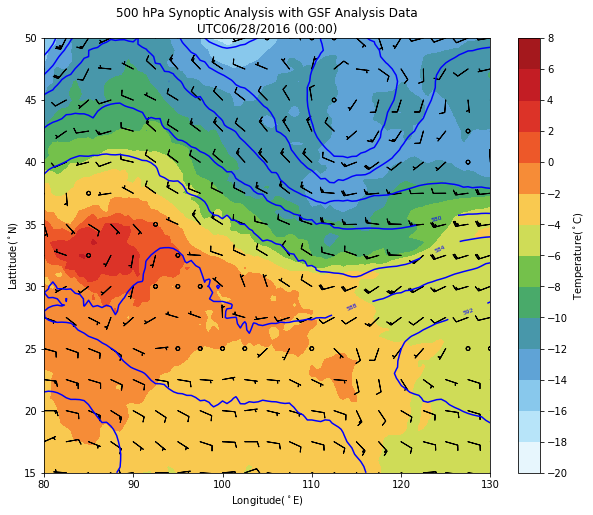

In [6]:
plt.figure(figsize=(10, 8))
plt.title('%g' % level +
          ' hPa Synoptic Analysis with GSF Analysis Data\nUTC' + time_str)
cf = plt.contourf(
    lon, lat, t_var, vmin=t_min, vmax=t_max,
    cmap=cmaps.WhiteBlueGreenYellowRed,
    levels=t_level)

cb = plt.colorbar(cf, ax=plt.gca(), ticks=t_level)
# 利用latex符号表示度
cb.set_label('$\mathrm{Temperature(^\circ C)}$')

cs = plt.contour(lon, lat, hgt_var, colors='b', levels=h_level)
plt.clabel(cs, cs.levels, fmt='%g', fontsize=6, inline_spacing=10)
plt.barbs(lon[::5, ::5], lat[::5, ::5], u_var[::5, ::5], v_var[::5, ::5],
          length=5)
plt.axis([lon_min, lon_max, lat_min, lat_max])
plt.xlabel('$\mathrm{Longitude(^\circ E)}$')
plt.ylabel('$\mathrm{Lattitude(^\circ N)}$')
plt.show()

以下部分是利用basemap将上图绘制到地图上

/Users/hhuang/Anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3630: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/hhuang/Anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3699: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/hhuang/Anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3527: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/hhuang/Anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3594: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/hhuang/Anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3821: MatplotlibDeprec

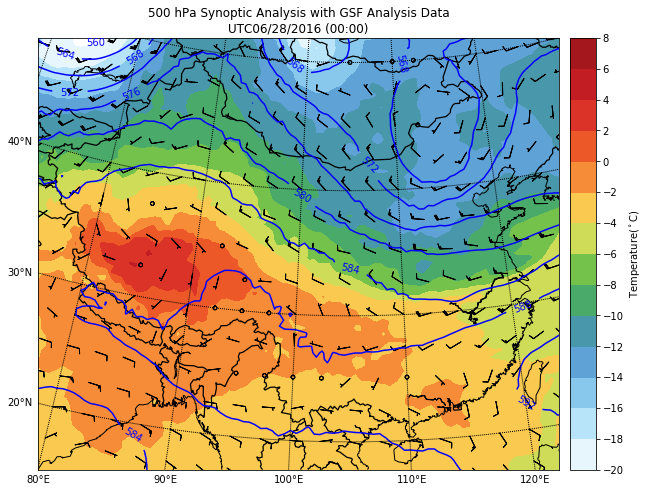

In [7]:
lat_0 = (lat_min + lat_max) / 2.
lon_0 = (lon_min + lon_max) / 2.
projection = 'lcc'
# projection = 'mill'
resolution = 'l'

area_thresh = 10000

plt.figure(figsize=(10, 8))
basemap = Basemap(
    llcrnrlon=lon_min, llcrnrlat=lat_min,
    urcrnrlon=lon_max, urcrnrlat=lat_max,
    lat_0=lat_0, lon_0=lon_0, projection=projection,
    area_thresh=area_thresh, resolution=resolution, ax=plt.gca())

basemap.drawcoastlines()
basemap.drawcountries(linewidth=1.25)
basemap.drawmeridians(np.arange(0, 360, 10),
                      labels=[False, False, False, True])
basemap.drawparallels(np.arange(-90, 90, 10),
                      labels=[True, False, False, False])
x0, y0 = basemap(lon, lat)
plt.title('%g' % level +
          ' hPa Synoptic Analysis with GSF Analysis Data\nUTC' + time_str)
cf = basemap.contourf(
    x0, y0, t_var, vmin=t_min, vmax=t_max,
    cmap=cmaps.WhiteBlueGreenYellowRed,
    levels=t_level)

cb = basemap.colorbar(cf, ax=plt.gca(), ticks=t_level)
cb.set_label('$\mathrm{Temperature(^\circ C)}$')

cs = basemap.contour(x0, y0, hgt_var, colors='b', levels=h_level)
plt.clabel(cs, cs.levels, fmt='%g', inline_spacing=10)
basemap.barbs(x0[::5, ::5], y0[::5, ::5], u_var[::5, ::5], v_var[::5, ::5],
              length=5)
plt.show()